In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline
plt.style.use("ggplot")

# Data processing

In [2]:
# load data
X = pd.read_excel("/Users/apple/Desktop/zest/Homework - Data Scientist.xlsx", sheet_name="Application Data")
y = pd.read_excel("/Users/apple/Desktop/zest/Homework - Data Scientist.xlsx", sheet_name="Loan Performance")

# drop unrecognized id
bad_id = [i for i, j in enumerate(list(X["customer_id"])) if isinstance(j, int) and len(str(j))!=10]
X = X.drop(bad_id)
X = X.reset_index(drop=True)

# dealing with special int id
for i, j in enumerate(list(X["customer_id"])):
    if isinstance(j, int):
        X.loc[i, "customer_id"] = str(X.loc[i, "customer_id"])

In [3]:
# dealing with unmatched y
y2_reg = list(y["idLoan"].apply(lambda x: re.search("2$", x)))
y2_ind = [i for i, j in enumerate(y2_reg) if j != None]
y = y.drop(y2_ind)
y = y.reset_index(drop=True)

y["idLoan"] = [i[:10].lower() for i in list(y["idLoan"])]
X['flgGood'] = 0

for i, j in enumerate(X["customer_id"]):
    if j in list(y["idLoan"]):    
        tmp_ind = y.index[y['idLoan'] == j]    
        flgGood = list(y['flgGood'].loc[tmp_ind])[0]
        if flgGood == "Good":
            X.loc[i, "flgGood"] = 1
    else:
        #print(i)
        #print(j)
        X = X.drop([i])

X = X.reset_index(drop=True)

In [4]:
# calculating age
from datetime import date

def calculate_age(born, today):
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

for i in range(len(X)):
    X.loc[i, "birth_date"] = calculate_age(X.loc[i, "birth_date"], X.loc[i, "application_when"])

X = X.drop(["application_when"], axis = 1)
X = X.rename(columns={"birth_date": "age"})

In [11]:
# binning age
for i in range(len(X)):
    if X.loc[i, "age"] < 20:
        X.loc[i, "age"] = "10s"
    elif X.loc[i, "age"] < 30:
        X.loc[i, "age"] = "20s"
    elif X.loc[i, "age"] < 40:
        X.loc[i, "age"] = "30s"
    elif X.loc[i, "age"] < 50:
        X.loc[i, "age"] = "40s"
    elif X.loc[i, "age"] < 60:
        X.loc[i, "age"] = "50s"
    elif X.loc[i, "age"] < 70:
        X.loc[i, "age"] = "60s"
    else:
        X.loc[i, "age"] = "70s"

In [13]:
# special case, drop no contribution variable
X = X.drop(["status"], axis = 1)

# if payment_amount_approved not available, using payment_amount value
for i in range(len(X)):
    if pd.isna(X.loc[i, "payment_amount_approved"]):
        X.loc[i, "payment_amount_approved"] = X.loc[i, "payment_amount"]
    
# if other_phone_type not available, filling in it with "None"
for i in range(len(X)):
    if pd.isna(X.loc[i, "other_phone_type"]):
        X.loc[i, "other_phone_type"] = "None"
        
# extract email type
start = [re.search("@", i).start() for i in list(X["email"])]
end = [re.search("\.", i).start() for i in list(X["email"])]
X["email"] = [X.loc[i, "email"][start[i]+1:end[i]] for i in range(len(X))]

# NaN value, impute with mode
X.loc[X["bank_account_duration"].isna(), "bank_account_duration"] = "3+ years"
X.loc[X["how_use_money"].isna(), "how_use_money"] = "Other"

In [15]:
# binning minority in "how_use_money"
for i, j in enumerate(list(X["how_use_money"])):
    if j in ["School", "Rent", "Rent / Mortgage", "Gifts / Leisure", "Won't say"]:
        X.loc[i, "how_use_money"] = "minority"
        
        
# code dummy variable
X = pd.get_dummies(X, columns=["age", "residence_rent_or_own", "bank_account_direct_deposit", "payment_ach", 
                           "email", "email_duration", "residence_duration", "bank_account_duration", 
                           "payment_frequency", "home_phone_type", "other_phone_type", "how_use_money"], 
              drop_first = True)

In [16]:
# Y = X["flgGood"]
X = X.drop(["customer_id"], axis = 1)

# train test split
np.random.seed(0)
ind = np.random.choice(len(X), int(0.3*len(X)), replace=False) 
test_ind = [i in ind for i in range(len(X))]
train_ind = [i not in ind for i in range(len(X))]

test = X.loc[test_ind, :]
test = test.reset_index(drop=True) 
#test_y = Y[test_ind]
#test_y = test_y.reset_index(drop=True) 

train = X.loc[train_ind, :]
train = train.reset_index(drop=True) 
#train_y = Y[train_ind]
#train_y = train_y.reset_index(drop=True) 

predictors = [x for x in X.columns if x not in ["flgGood"]]
#response = "flgGood"

# EDA

In [25]:
X.columns

Index(['amount_requested', 'monthly_rent_amount', 'loan_duration',
       'num_payments', 'payment_amount', 'amount_approved',
       'duration_approved', 'payment_amount_approved', 'address_zip',
       'bank_routing_number', 'monthly_income_amount', 'raw_l2c_score',
       'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card',
       'raw_FICO_money', 'flgGood', 'age_20s', 'age_30s', 'age_40s', 'age_50s',
       'age_60s', 'age_70s', 'residence_rent_or_own_True',
       'bank_account_direct_deposit_True', 'payment_ach_True', 'email_bing',
       'email_gmail', 'email_hotmail', 'email_yahoo',
       'email_duration_3 months or less', 'email_duration_4-12 months',
       'residence_duration_3+ years', 'residence_duration_6 months or less',
       'residence_duration_7-12 months', 'bank_account_duration_3+ years',
       'bank_account_duration_6 months or less',
       'bank_account_duration_7-12 months', 'payment_frequency_Monthly',
       'payment_frequency_Semi-monthly', 'payme

In [ ]:
plt.hist(X.loc[X["flgGood"] == 0, "raw_l2c_score"], bins=30, label = "bad")
plt.hist(X.loc[X["flgGood"] == 1, "raw_l2c_score"], bins=30, label = "good")
plt.legend()
plt.title("raw_l2c_score")
plt.show()

# Logistic Regression

In [117]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

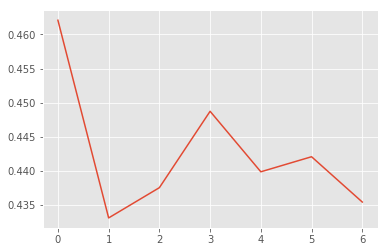

In [187]:
# k-fold: choosing best hyperparameter
log_reg_Cs = [1, 2, 3, 4, 5, 6, 7]
CVs = []

for i in log_reg_Cs:
    tmp_lr = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter=1000, C = i)
    tmp_cv = cross_val_score(tmp_lr, train[predictors], train["flgGood"], cv=4, scoring="accuracy")
    CVs.append(1-np.mean(tmp_cv))

plt.plot(CVs)
plt.show()

In [242]:
# fitting and evaluating model

log_reg = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter=200, C = 1)

log_reg.fit(train[predictors], train["flgGood"])
print("Accuracy: ", np.mean(log_reg.predict(test[predictors]) == test["flgGood"]))
fpr, tpr, thresholds = metrics.roc_curve(test["flgGood"], log_reg.predict_proba(test[predictors])[:, 1])
print("AUC: ", metrics.auc(fpr, tpr))
print("F-1 score: ", metrics.f1_score(test["flgGood"], log_reg.predict(test[predictors])))

Accuracy:  0.640625
AUC:  0.6493874773139745
F-1 score:  0.5660377358490565


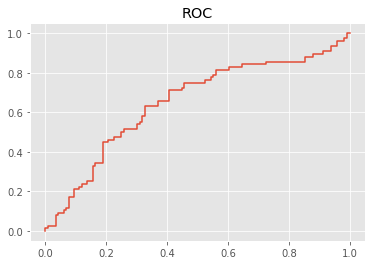

In [244]:
plt.plot(fpr, tpr)
plt.title("ROC")
plt.show()

# Gradient Boosting

In [263]:
# grid search best tree-specific parameters using k-fold
param_test1 = {'n_estimators': range(20, 81, 10), 'max_depth':range(5,16,2), 'min_samples_split':range(20,61,10),
               'min_samples_leaf':range(10,31,10), 'max_features':range(7,20,2)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(), 
                       param_grid = param_test1, scoring='accuracy',n_jobs=10,iid=False, cv=5)
gsearch1.fit(train[predictors], train["flgGood"])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=10,
       param_grid={'n_estimators': range(20, 81, 10), 'max_depth': range(5, 16, 2), 'min_samples_split': range(20, 61, 10), 'min_samples_leaf': range(10, 31, 10), 'max_features': range(7, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [268]:
gsearch1.best_params_

{'max_depth': 7,
 'max_features': 15,
 'min_samples_leaf': 20,
 'min_samples_split': 60,
 'n_estimators': 50}

In [271]:
# grid search best boosting parameters using k-fold
param_test2 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9], 'learning_rate': [0.005, 0.05, 0.01]}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=50, max_depth=7, max_features=15,
                                                              min_samples_leaf=20, min_samples_split=60), 
                       param_grid = param_test2, scoring='accuracy', n_jobs=-1, iid=False, cv=5)
gsearch2.fit(train[predictors], train["flgGood"])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=15, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_sample...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9], 'learning_rate': [0.005, 0.05, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [272]:
gsearch2.best_params_

{'learning_rate': 0.01, 'subsample': 0.6}

In [273]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=7, max_features=15, min_samples_leaf=20, 
                                min_samples_split=60, learning_rate=0.01, subsample=0.6)

gb.fit(train[predictors], train["flgGood"])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features=15, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=60,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.6, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [274]:
np.mean(gb.predict(train.drop(["flgGood"], axis = 1)) == train["flgGood"])

0.7142857142857143

In [275]:
np.mean(gb.predict(test[predictors]) == test["flgGood"])

0.5989583333333334

In [276]:
print("Accuracy: ", np.mean(gb.predict(test[predictors]) == test["flgGood"]))
fpr, tpr, thresholds = metrics.roc_curve(test["flgGood"], gb.predict_proba(test[predictors])[:, 1])
print("AUC: ", metrics.auc(fpr, tpr))
print("F-1 score: ", metrics.f1_score(test["flgGood"], gb.predict(test[predictors])))

Accuracy:  0.5989583333333334
AUC:  0.5835980036297641
F-1 score:  0.43795620437956206


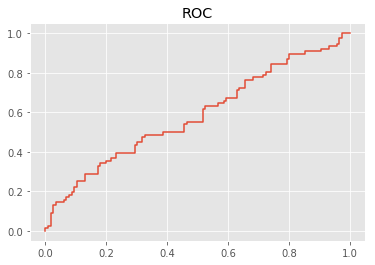

In [277]:
plt.plot(fpr, tpr)
plt.title("ROC")
plt.show()

In [267]:
gsearch1.cv_results_

{'mean_fit_time': array([0.11279354, 0.13437471, 0.16574364, ..., 0.23993554, 0.26999865,
        0.21391644]),
 'std_fit_time': array([0.02536502, 0.00621621, 0.00780614, ..., 0.01304233, 0.00907622,
        0.01661692]),
 'mean_score_time': array([0.00976458, 0.00874252, 0.00193982, ..., 0.00194702, 0.00441465,
        0.00204339]),
 'std_score_time': array([9.87809420e-03, 9.01065526e-03, 1.08164432e-04, ...,
        6.02882476e-05, 4.83344972e-03, 3.89964955e-04]),
 'param_max_depth': masked_array(data=[5, 5, 5, ..., 15, 15, 15],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[7, 7, 7, ..., 19, 19, 19],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[10, 10, 10, ..., 30, 30, 30],
              mask=[False, False, False, ..., False, False, False],
       